In [1]:
# Load various imports
import numpy as np
import pandas as pd
import os
import librosa
import ast

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sn

from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


### Função para extrair MFCCs de um ficheiro de áudio:

In [2]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccs

Extrai 13 listas de 173 valores:<br>data_exp.shape = (13, 173), ou seja 13 coeficientes para cada 1 dos 173 bins<br>axis=0 significa ao longo da coluna

In [3]:
filename = 'US8KS/air_conditioner.wav'
data_exp=extract_features(filename)
data_exp[0] #coeficiente 1 de cada um dos bins

array([ -99.52138371,  -95.63282042, -100.12341741, -100.70122596,
        -99.45521207,  -96.40714169,  -99.933068  ,  -96.44667069,
        -97.50029833,  -95.93855432,  -96.01259157,  -92.02787065,
        -90.19983378,  -97.47124369,  -97.44046654,  -91.1887362 ,
        -88.24488463,  -88.79596921,  -96.71088267,  -99.30292995,
       -102.74057043, -110.05231804, -106.57563549, -107.65112754,
       -109.66976228, -110.53902435, -105.44110964, -105.82342372,
       -100.64986179, -100.30121713, -103.45508264, -101.92058453,
       -104.71623278, -109.79366433, -106.23663077, -105.36616952,
       -106.43210086, -101.86303378, -101.30235647, -108.03104266,
       -109.31594181, -108.01401279, -106.19663018, -103.21077939,
       -103.32591809, -101.82475344,  -95.87184241,  -98.78841907,
       -103.2397737 , -105.82483691, -105.32259361, -107.83412291,
       -108.57408961, -108.11336171, -109.58814405, -106.13161209,
       -105.85176246, -105.04204422, -109.04946703, -109.86780

np.mean faz uma média de um coefficiente presente em todos os bins<br>ou seja, percorre todo o eixo do x (x entre 1 e 173) e faz uma média de todos os valores do coeficiente y (y entre 1 e 13)

In [4]:
filename = 'US8KS/air_conditioner.wav'
data_exp=extract_features(filename)
data_exp[0]
mean=np.mean(data_exp.T, axis=0)
mean

array([-106.46682237,  136.71918919,  -25.21238863,  -12.05361479,
        -36.01345889,    2.04263642,  -20.93445954,    9.67050199,
        -20.30589893,    9.54605096,  -18.13892437,   14.47279988,
        -18.11036677,    8.23589526,   -5.80958402,    8.30845388,
          1.22717159,    6.68601397,   -5.38474497,    5.97160894,
         -6.18474851,    3.27458736,   -5.87643058,    1.95203088,
         -3.55476466,    1.37579153,   -5.82514429,   -1.41227798,
         -0.59397715,    3.56402955,   -0.66262974,    2.21782646,
         -0.59240748,    5.15843175,   -0.52447846,    2.59311941,
         -1.17877105,    0.70740442,   -2.30029954,    0.89879733])

In [5]:
# Read the metadata
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [6]:
# # Set the path to the full UrbanSound dataset 
# fulldatasetpath = '/Users/pedro/OneDrive - Universidade do Porto/Tese/UrbanSound8K/audio/'

# # Read the metadata
# metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

# features = []

# # Iterate through each sound file and extract the features 
# for index, row in metadata.iterrows():
    
#     file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
#     class_label = row["class_name"]
#     data = extract_features(file_name)
    
#     features.append([data, class_label])

# # Convert into a Panda dataframe 
# featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

# print('Finished feature extraction from ', len(featuresdf), ' files')

In [7]:
#featuresdf

In [8]:
# def transform_to_list(row):
#     return row.feature.tolist()
# featuresdf["feature"] = featuresdf.apply(transform_to_list, axis=1)

In [9]:
# featuresdf.to_csv("13MFCCs.csv", sep="|", index=False)

In [10]:
new_featuresdf = pd.read_csv("40MFCCs.csv", sep="|")
new_featuresdf

,feature,class_label
0,"[-215.79300197978586, 71.6661218577675, -131.8...",dog_bark
1,"[-424.68685717404645, 110.56227614968253, -54....",children_playing
2,"[-459.56466281715973, 122.80034862683691, -47....",children_playing
3,"[-414.55377053561494, 102.89690543200295, -36....",children_playing
4,"[-447.39699928170836, 115.09538477641466, -53....",children_playing
...,...,...
8727,"[-399.2257209098363, 136.81901320524457, -51.9...",car_horn
8728,"[-346.7273127859397, 87.4884743538864, -46.265...",car_horn
8729,"[-304.6131609118385, 112.61991286445974, -47.1...",car_horn
8730,"[-344.7142096344138, 126.7581432632123, -56.17...",car_horn


In [11]:
def convert_to_list(row):
    return ast.literal_eval(row.feature)
new_featuresdf['feature'] = new_featuresdf.apply(convert_to_list, axis=1)

In [12]:
new_featuresdf

,feature,class_label
0,"[-215.79300197978586, 71.6661218577675, -131.8...",dog_bark
1,"[-424.68685717404645, 110.56227614968253, -54....",children_playing
2,"[-459.56466281715973, 122.80034862683691, -47....",children_playing
3,"[-414.55377053561494, 102.89690543200295, -36....",children_playing
4,"[-447.39699928170836, 115.09538477641466, -53....",children_playing
...,...,...
8727,"[-399.2257209098363, 136.81901320524457, -51.9...",car_horn
8728,"[-346.7273127859397, 87.4884743538864, -46.265...",car_horn
8729,"[-304.6131609118385, 112.61991286445974, -47.1...",car_horn
8730,"[-344.7142096344138, 126.7581432632123, -56.17...",car_horn


In [13]:
new_featuresdf.feature[0]

[-215.79300197978586,
 71.6661218577675,
 -131.8137710605355,
 -52.09133106039041,
 -22.115966541692504,
 -21.764182004937346,
 -11.18374714512825,
 18.91268019506631,
 6.726638568856883,
 14.55689415517604,
 -11.782045895784535,
 2.301036870326384,
 -17.25130422975169,
 10.052420985567606,
 -6.009499016993739,
 -1.3153193298385262,
 -17.693509787734364,
 1.1171223735902036,
 -4.369944723364342,
 7.262952837804102,
 -11.81597010019415,
 -7.495261552200067,
 5.4577132249598765,
 -2.944245465389455,
 -5.869388859452769,
 -0.09865485502752598,
 -3.2121700561250046,
 4.609251174932417,
 -5.8293269146817055,
 -5.347507326362163,
 1.3341219222914416,
 7.130782488071522,
 -0.07944967151592043,
 1.7109244794526912,
 -5.69420010137072,
 -2.9041713698169107,
 3.036695849692799,
 -1.6827588906866613,
 -0.8858582209870957,
 0.35438893556506207]

In [14]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(new_featuresdf.feature.tolist())
y = np.array(new_featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) #Transforms class labels into binary vectores with 1 on the respective class

In [15]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [16]:
print(x_train.shape)
x_train

(6985, 40)


array([[-8.89295311e+01,  1.17308969e+02, -9.83756467e+01, ...,
         2.18912894e+00,  5.62749308e+00, -3.90323362e+00],
       [-1.62974918e+02,  1.35343873e+02, -2.69913125e+01, ...,
        -3.04390911e+00, -4.27310610e+00,  1.13195915e+00],
       [-2.62997811e+02,  1.78106043e+02, -1.12845692e+02, ...,
         4.20665671e-01,  2.10970697e+00, -1.70939643e+00],
       ...,
       [-2.90996012e+02,  2.33350964e+02, -4.67256500e+00, ...,
         2.80807376e-01, -3.53280783e-01, -1.44006166e-02],
       [-2.01696558e+02,  9.35907247e+01, -8.08604206e+01, ...,
        -4.83238895e-01, -2.12509316e+00,  5.01021329e+00],
       [-2.71514732e+02,  1.35730344e+02, -9.02778043e+00, ...,
        -1.63706314e+00, -1.90793733e+00, -1.69450595e-01]])

In [17]:
print(x_test.shape)
x_test

(1747, 40)


array([[-8.21235894e+01,  1.39505916e+02, -4.24308649e+01, ...,
        -5.02371148e-01, -2.60428533e+00, -1.05346291e+00],
       [-1.57440054e+01,  1.24119960e+02, -2.94288813e+01, ...,
         8.23705630e-01,  1.71932210e+00, -3.31462349e-01],
       [-1.23393651e+02,  1.51819463e+01, -5.00933290e+01, ...,
         1.57439023e+00, -3.99674190e+00,  3.24574944e+00],
       ...,
       [-4.05091674e+02,  1.55382151e+02,  3.08756216e+01, ...,
        -3.30258332e+00, -3.44398601e+00, -6.52839691e-01],
       [-1.69869082e+02,  9.26223982e+01, -4.04844988e+00, ...,
         1.87711655e-01, -3.35710560e+00, -3.33799714e+00],
       [-1.96620974e+02,  1.52144648e+02, -5.74574410e+01, ...,
        -1.52897450e+00, -2.82955607e+00, -3.17450853e+00]])

In [18]:
print(y_train.shape)
y_train

(6985, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [19]:
print(y_test.shape)
y_test

(1747, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Logistic Regression

Dá para fazer logistic regression com CV já incorporada, pesquisar no sklearn

In [72]:
model = LogisticRegression(multi_class='ovr',max_iter=550)

O seguinte passo basicamente retorna um vetor com os índices das labels de cada sample <br>
np.argmax returnes the indices of the highest values

In [21]:
y_train_one_column = []
for one_hot_array in y_train:
    y_train_one_column.append(str(np.argmax(one_hot_array)))
y_train_one_column = np.array(y_train_one_column)
y_test_one_column = []
for one_hot_array in y_test:
    y_test_one_column.append(str(np.argmax(one_hot_array)))
y_test_one_column = np.array(y_test_one_column)

In [22]:
print(y_train_one_column.shape)
y_train_one_column

(6985,)


array(['8', '9', '8', ..., '0', '8', '8'], dtype='<U1')

In [23]:
print(y_test_one_column.shape)
y_test_one_column

(1747,)


array(['8', '9', '4', ..., '5', '9', '8'], dtype='<U1')

In [73]:
model.fit(x_train, y_train_one_column)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=550,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
model.score(x_test, y_test_one_column)

0.5758443045220378

In [75]:
y_predicted = model.predict(x_test)

In [76]:
cm = confusion_matrix(y_test_one_column, y_predicted)
cm

array([[108,   1,   8,   1,   9,  21,   0,  14,   9,  32],
       [  3,  65,   2,   1,   2,   4,   2,   5,   0,   2],
       [ 20,   0,  96,  20,  12,   8,   1,   2,   7,  17],
       [ 10,   3,  12, 136,   9,   7,   1,   0,  14,   9],
       [ 12,   1,  14,   5, 115,   7,   1,  30,   9,  12],
       [ 38,   0,   7,   2,   2, 104,   0,  22,   8,  10],
       [  1,   1,   0,  34,   6,   0,   7,   2,   1,  20],
       [ 12,   1,   1,   0,  29,  10,   0, 145,   3,   7],
       [  9,   0,   6,   5,   0,  13,   1,   2, 129,   0],
       [ 35,   4,  28,   9,  20,  13,   0,  15,   5, 101]], dtype=int64)

Text(68.09375, 0.5, 'Truth')

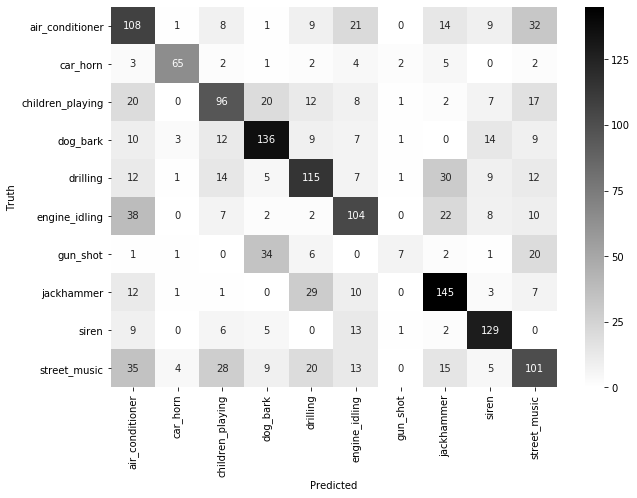

In [77]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

Pôr normalize='true' é basicamente dizer que se quer obter a precisão.

In [78]:
cm = confusion_matrix(y_test_one_column, y_predicted, normalize='true')*100
cm

array([[53.20197044,  0.49261084,  3.9408867 ,  0.49261084,  4.43349754,
        10.34482759,  0.        ,  6.89655172,  4.43349754, 15.7635468 ],
       [ 3.48837209, 75.58139535,  2.3255814 ,  1.1627907 ,  2.3255814 ,
         4.65116279,  2.3255814 ,  5.81395349,  0.        ,  2.3255814 ],
       [10.92896175,  0.        , 52.45901639, 10.92896175,  6.55737705,
         4.3715847 ,  0.54644809,  1.09289617,  3.82513661,  9.28961749],
       [ 4.97512438,  1.49253731,  5.97014925, 67.66169154,  4.47761194,
         3.48258706,  0.49751244,  0.        ,  6.96517413,  4.47761194],
       [ 5.82524272,  0.48543689,  6.7961165 ,  2.42718447, 55.82524272,
         3.39805825,  0.48543689, 14.5631068 ,  4.36893204,  5.82524272],
       [19.68911917,  0.        ,  3.62694301,  1.03626943,  1.03626943,
        53.88601036,  0.        , 11.39896373,  4.14507772,  5.18134715],
       [ 1.38888889,  1.38888889,  0.        , 47.22222222,  8.33333333,
         0.        ,  9.72222222,  2.77777778

Text(68.09375, 0.5, 'Truth')

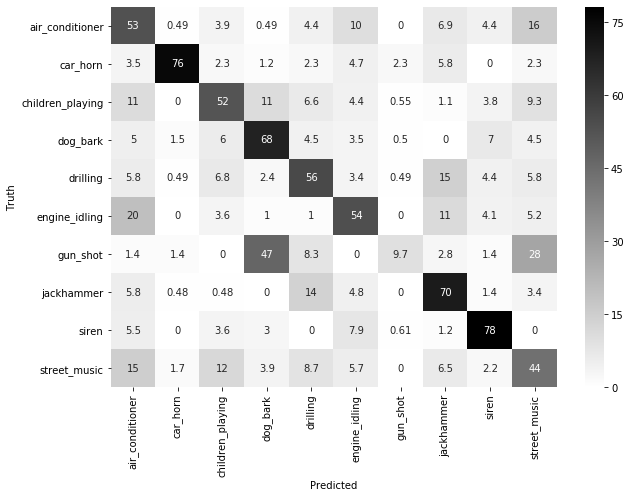

In [79]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Random Forest

* number of decision trees used (n_estimators): 20
* criterion (gini  or entropy): gini
* seed used by the random state generator for randomizing the dataset (random_state): 42

In [31]:
# training a Random Forest classifier
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(x_train, y_train_one_column)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
model.score(x_test, y_test_one_column)

0.8580423583285632

In [33]:
y_predicted = model.predict(x_test)

In [34]:
cm = confusion_matrix(y_test_one_column, y_predicted)
cm

array([[192,   0,   3,   0,   2,   0,   0,   2,   1,   3],
       [  5,  68,   2,   1,   3,   0,   0,   3,   0,   4],
       [  4,   0, 153,  12,   5,   0,   0,   3,   1,   5],
       [  3,   1,  15, 168,   3,   1,   0,   0,   6,   4],
       [  5,   0,   5,   6, 170,   0,   0,  10,   1,   9],
       [  0,   0,   2,   1,   0, 186,   0,   2,   1,   1],
       [  2,   0,   7,   6,   0,   1,  54,   0,   0,   2],
       [  1,   0,   0,   1,  12,   0,   0, 193,   0,   1],
       [  3,   0,   3,   6,   1,   0,   0,   0, 152,   0],
       [  9,   0,  32,   9,   7,   3,   0,   2,   5, 163]], dtype=int64)

Text(68.09375, 0.5, 'Truth')

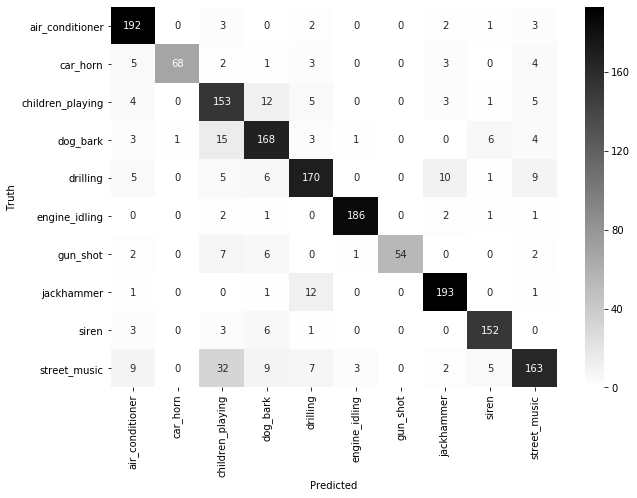

In [35]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
cm = confusion_matrix(y_test_one_column, y_predicted, normalize='true')*100
cm

array([[94.58128079,  0.        ,  1.47783251,  0.        ,  0.98522167,
         0.        ,  0.        ,  0.98522167,  0.49261084,  1.47783251],
       [ 5.81395349, 79.06976744,  2.3255814 ,  1.1627907 ,  3.48837209,
         0.        ,  0.        ,  3.48837209,  0.        ,  4.65116279],
       [ 2.18579235,  0.        , 83.60655738,  6.55737705,  2.73224044,
         0.        ,  0.        ,  1.63934426,  0.54644809,  2.73224044],
       [ 1.49253731,  0.49751244,  7.46268657, 83.58208955,  1.49253731,
         0.49751244,  0.        ,  0.        ,  2.98507463,  1.99004975],
       [ 2.42718447,  0.        ,  2.42718447,  2.91262136, 82.52427184,
         0.        ,  0.        ,  4.85436893,  0.48543689,  4.36893204],
       [ 0.        ,  0.        ,  1.03626943,  0.51813472,  0.        ,
        96.37305699,  0.        ,  1.03626943,  0.51813472,  0.51813472],
       [ 2.77777778,  0.        ,  9.72222222,  8.33333333,  0.        ,
         1.38888889, 75.        ,  0.        

Text(68.09375, 0.5, 'Truth')

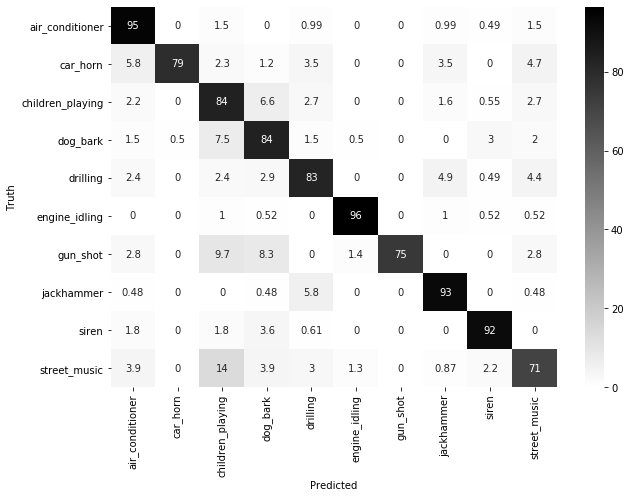

In [37]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Feed-forward Neural Network

In [38]:
num_labels = y_train.shape[1]

N=1

model = Sequential()

model.add(Dense(1024, input_shape=(40,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))

for i in range(N-1):
    model.add(Dense(1024))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, batch_size=32, epochs=500)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/500





6985/6985 [==============================] - 1s 138us/step - loss: 1.6841 - acc: 0.4319
Epoch 2/500
6985/6985 [==============================] - 1s 76us/step - loss: 1.2539 - acc: 0.5674
Epoch 3/500
6985/6985 [==============================] - 1s 74us/step - loss: 1.0808 - acc: 0.6352
Epoch 4/500
6985/6985 [==============================] - 1s 73us/step - loss: 0.9644 - acc: 0.6786
Epoch 5/500
6985/6985 [==============================] - 1s 74us/step - loss: 0.8869 - acc: 0.7052
Epoch 6/500
6985/6985 [==============================] - 0s 68us/step - loss: 0.8146 - acc: 0.7337
Epoch 7/500
6985/6985 [==============================] - 0s 69us/step - loss: 0.7710 - acc: 0.7457
Epoch 8/500
6985/6985 [==============================] - 0s 68us/step - loss: 0.723

6985/6985 [==============================] - 1s 74us/step - loss: 0.2531 - acc: 0.9110
Epoch 49/500
6985/6985 [==============================] - 1s 151us/step - loss: 0.2668 - acc: 0.9097
Epoch 50/500
6985/6985 [==============================] - 0s 69us/step - loss: 0.2512 - acc: 0.9134
Epoch 51/500
6985/6985 [==============================] - 0s 64us/step - loss: 0.2603 - acc: 0.9151
Epoch 52/500
6985/6985 [==============================] - 0s 65us/step - loss: 0.2519 - acc: 0.9107
Epoch 53/500
6985/6985 [==============================] - 1s 74us/step - loss: 0.2335 - acc: 0.9221
Epoch 54/500
6985/6985 [==============================] - 1s 84us/step - loss: 0.2510 - acc: 0.9117
Epoch 55/500
6985/6985 [==============================] - 0s 65us/step - loss: 0.2396 - acc: 0.9181
Epoch 56/500
6985/6985 [==============================] - 1s 102us/step - loss: 0.2467 - acc: 0.9198
Epoch 57/500
6985/6985 [==============================] - 1s 84us/step - loss: 0.2443 - acc: 0.9165
Epoch 58/50

6985/6985 [==============================] - 1s 117us/step - loss: 0.1428 - acc: 0.9492
Epoch 129/500
6985/6985 [==============================] - 1s 124us/step - loss: 0.1451 - acc: 0.9502
Epoch 130/500
6985/6985 [==============================] - 1s 128us/step - loss: 0.1489 - acc: 0.9487
Epoch 131/500
6985/6985 [==============================] - 1s 153us/step - loss: 0.1450 - acc: 0.9502
Epoch 132/500
6985/6985 [==============================] - 1s 132us/step - loss: 0.1426 - acc: 0.9512
Epoch 133/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.1518 - acc: 0.9480
Epoch 134/500
6985/6985 [==============================] - 1s 121us/step - loss: 0.1489 - acc: 0.9479
Epoch 135/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.1409 - acc: 0.9539
Epoch 136/500
6985/6985 [==============================] - 1s 129us/step - loss: 0.1345 - acc: 0.9565
Epoch 137/500
6985/6985 [==============================] - 1s 122us/step - loss: 0.1443 - acc: 0

6985/6985 [==============================] - 1s 123us/step - loss: 0.1246 - acc: 0.9581
Epoch 209/500
6985/6985 [==============================] - 1s 132us/step - loss: 0.1132 - acc: 0.9618
Epoch 210/500
6985/6985 [==============================] - 1s 162us/step - loss: 0.1217 - acc: 0.9578
Epoch 211/500
6985/6985 [==============================] - 1s 138us/step - loss: 0.1146 - acc: 0.9638
Epoch 212/500
6985/6985 [==============================] - 1s 164us/step - loss: 0.1236 - acc: 0.9578
Epoch 213/500
6985/6985 [==============================] - 1s 127us/step - loss: 0.1136 - acc: 0.9602
Epoch 214/500
6985/6985 [==============================] - 1s 134us/step - loss: 0.1049 - acc: 0.9621
Epoch 215/500
6985/6985 [==============================] - 1s 129us/step - loss: 0.1118 - acc: 0.9601
Epoch 216/500
6985/6985 [==============================] - 1s 134us/step - loss: 0.1071 - acc: 0.9655
Epoch 217/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.1170 - acc: 0

6985/6985 [==============================] - 1s 121us/step - loss: 0.0978 - acc: 0.9666
Epoch 289/500
6985/6985 [==============================] - 1s 120us/step - loss: 0.0992 - acc: 0.9646
Epoch 290/500
6985/6985 [==============================] - 1s 121us/step - loss: 0.1041 - acc: 0.9654
Epoch 291/500
6985/6985 [==============================] - 1s 120us/step - loss: 0.0987 - acc: 0.9671
Epoch 292/500
6985/6985 [==============================] - 1s 130us/step - loss: 0.1021 - acc: 0.9654
Epoch 293/500
6985/6985 [==============================] - 1s 131us/step - loss: 0.1058 - acc: 0.9655
Epoch 294/500
6985/6985 [==============================] - 1s 136us/step - loss: 0.0898 - acc: 0.9695
Epoch 295/500
6985/6985 [==============================] - 1s 137us/step - loss: 0.0932 - acc: 0.9675
Epoch 296/500
6985/6985 [==============================] - 1s 129us/step - loss: 0.1052 - acc: 0.9652
Epoch 297/500
6985/6985 [==============================] - 1s 132us/step - loss: 0.0964 - acc: 0

6985/6985 [==============================] - 1s 123us/step - loss: 0.0987 - acc: 0.9671
Epoch 369/500
6985/6985 [==============================] - 1s 122us/step - loss: 0.0920 - acc: 0.9682
Epoch 370/500
6985/6985 [==============================] - 1s 124us/step - loss: 0.0787 - acc: 0.9728
Epoch 371/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.0893 - acc: 0.9718
Epoch 372/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.0832 - acc: 0.9717
Epoch 373/500
6985/6985 [==============================] - 1s 119us/step - loss: 0.0906 - acc: 0.9692
Epoch 374/500
6985/6985 [==============================] - 1s 119us/step - loss: 0.0800 - acc: 0.9731
Epoch 375/500
6985/6985 [==============================] - 1s 131us/step - loss: 0.0799 - acc: 0.9715
Epoch 376/500
6985/6985 [==============================] - 1s 122us/step - loss: 0.0813 - acc: 0.9735
Epoch 377/500
6985/6985 [==============================] - 1s 120us/step - loss: 0.1003 - acc: 0

6985/6985 [==============================] - 1s 151us/step - loss: 0.0934 - acc: 0.9671
Epoch 448/500
6985/6985 [==============================] - 1s 129us/step - loss: 0.0808 - acc: 0.9719
Epoch 449/500
6985/6985 [==============================] - 1s 128us/step - loss: 0.0793 - acc: 0.9749
Epoch 450/500
6985/6985 [==============================] - 1s 129us/step - loss: 0.0766 - acc: 0.9738
Epoch 451/500
6985/6985 [==============================] - 1s 123us/step - loss: 0.0838 - acc: 0.9722
Epoch 452/500
6985/6985 [==============================] - 1s 136us/step - loss: 0.0835 - acc: 0.9704
Epoch 453/500
6985/6985 [==============================] - 1s 128us/step - loss: 0.0802 - acc: 0.9711
Epoch 454/500
6985/6985 [==============================] - 1s 133us/step - loss: 0.0796 - acc: 0.9704
Epoch 455/500
6985/6985 [==============================] - 1s 120us/step - loss: 0.0871 - acc: 0.9691
Epoch 456/500
6985/6985 [==============================] - 1s 119us/step - loss: 0.0714 - acc: 0

In [39]:
y_predicted = model.predict(x_test)

In [40]:
new_y_predicted=list()
for i in y_predicted:
    maximum = max(i)
    new_list = [int(element==maximum) for element in i]
    new_y_predicted.append(new_list)
y_predicted_one_column = list()
for one_hot_array in new_y_predicted:
    y_predicted_one_column.append(str(np.argmax(one_hot_array)))
y_predicted_one_column = np.array(y_predicted_one_column)

In [41]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column)
cm

array([[194,   0,   1,   0,   0,   4,   2,   0,   1,   1],
       [  1,  76,   0,   3,   0,   1,   0,   0,   0,   5],
       [  1,   0, 170,   3,   0,   0,   0,   0,   1,   8],
       [  1,   0,   4, 180,   4,   0,   3,   1,   4,   4],
       [  2,   0,   7,   1, 185,   0,   0,   4,   1,   6],
       [  0,   0,   3,   0,   0, 189,   0,   0,   0,   1],
       [  0,   0,   3,   3,   0,   0,  64,   0,   2,   0],
       [  0,   0,   0,   0,   8,   0,   0, 199,   0,   1],
       [  0,   0,   1,   1,   0,   0,   0,   0, 163,   0],
       [  4,   0,  12,   6,   1,   4,   0,   0,   4, 199]], dtype=int64)

Text(68.09375, 0.5, 'Truth')

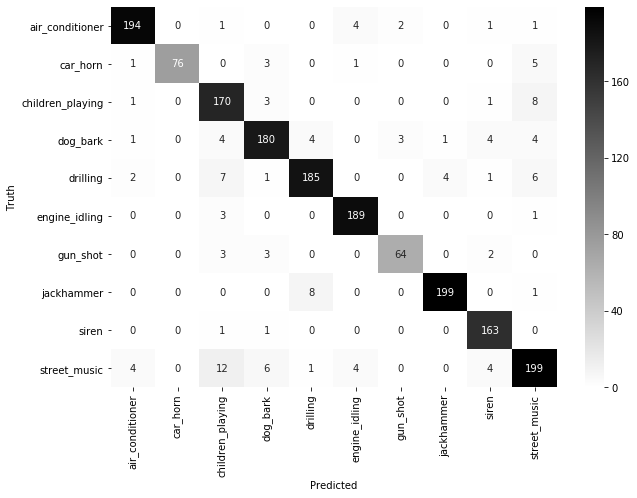

In [42]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [43]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column, normalize='true')*100
cm

array([[95.56650246,  0.        ,  0.49261084,  0.        ,  0.        ,
         1.97044335,  0.98522167,  0.        ,  0.49261084,  0.49261084],
       [ 1.1627907 , 88.37209302,  0.        ,  3.48837209,  0.        ,
         1.1627907 ,  0.        ,  0.        ,  0.        ,  5.81395349],
       [ 0.54644809,  0.        , 92.89617486,  1.63934426,  0.        ,
         0.        ,  0.        ,  0.        ,  0.54644809,  4.3715847 ],
       [ 0.49751244,  0.        ,  1.99004975, 89.55223881,  1.99004975,
         0.        ,  1.49253731,  0.49751244,  1.99004975,  1.99004975],
       [ 0.97087379,  0.        ,  3.39805825,  0.48543689, 89.80582524,
         0.        ,  0.        ,  1.94174757,  0.48543689,  2.91262136],
       [ 0.        ,  0.        ,  1.55440415,  0.        ,  0.        ,
        97.92746114,  0.        ,  0.        ,  0.        ,  0.51813472],
       [ 0.        ,  0.        ,  4.16666667,  4.16666667,  0.        ,
         0.        , 88.88888889,  0.        

Text(68.09375, 0.5, 'Truth')

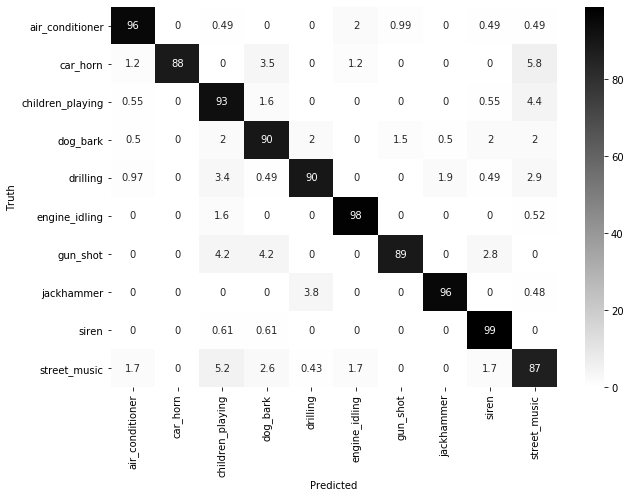

In [44]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
new_y_predicted

[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0,

# k Nearest Neighbors

In [46]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 1).fit(x_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(x_test, y_test) 
print (accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(x_test)
y_predicted_one_column = list()
for one_hot_array in knn_predictions:
    y_predicted_one_column.append(str(np.argmax(one_hot_array)))
y_predicted_one_column = np.array(y_predicted_one_column)
cm = confusion_matrix(y_test_one_column, y_predicted_one_column)
cm

0.9004006868918145


array([[191,   1,   4,   1,   2,   2,   0,   0,   0,   2],
       [  1,  68,   6,   2,   0,   1,   3,   1,   1,   3],
       [  4,   0, 171,   1,   0,   0,   6,   0,   0,   1],
       [  2,   0,   7, 164,   4,   3,  14,   0,   5,   2],
       [  2,   1,   6,   0, 184,   0,   3,   4,   2,   4],
       [  0,   0,   3,   2,   0, 187,   0,   1,   0,   0],
       [  2,   0,   3,   1,   1,   0,  62,   0,   0,   3],
       [  0,   1,   3,   0,   5,   0,   0, 195,   1,   3],
       [  1,   0,   1,   1,   0,   0,   1,   0, 161,   0],
       [ 10,   0,  15,   4,   2,   3,   4,   1,   1, 190]], dtype=int64)

Text(68.09375, 0.5, 'Truth')

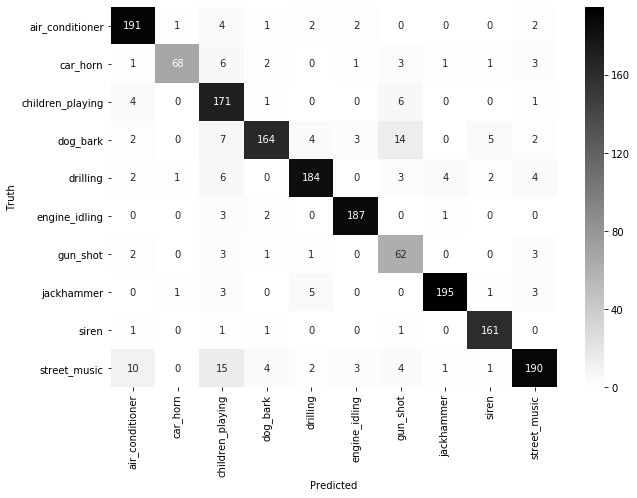

In [47]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
cm = confusion_matrix(y_test_one_column, y_predicted_one_column, normalize='true')*100
cm

array([[94.08866995,  0.49261084,  1.97044335,  0.49261084,  0.98522167,
         0.98522167,  0.        ,  0.        ,  0.        ,  0.98522167],
       [ 1.1627907 , 79.06976744,  6.97674419,  2.3255814 ,  0.        ,
         1.1627907 ,  3.48837209,  1.1627907 ,  1.1627907 ,  3.48837209],
       [ 2.18579235,  0.        , 93.44262295,  0.54644809,  0.        ,
         0.        ,  3.27868852,  0.        ,  0.        ,  0.54644809],
       [ 0.99502488,  0.        ,  3.48258706, 81.5920398 ,  1.99004975,
         1.49253731,  6.96517413,  0.        ,  2.48756219,  0.99502488],
       [ 0.97087379,  0.48543689,  2.91262136,  0.        , 89.32038835,
         0.        ,  1.45631068,  1.94174757,  0.97087379,  1.94174757],
       [ 0.        ,  0.        ,  1.55440415,  1.03626943,  0.        ,
        96.89119171,  0.        ,  0.51813472,  0.        ,  0.        ],
       [ 2.77777778,  0.        ,  4.16666667,  1.38888889,  1.38888889,
         0.        , 86.11111111,  0.        

Text(68.09375, 0.5, 'Truth')

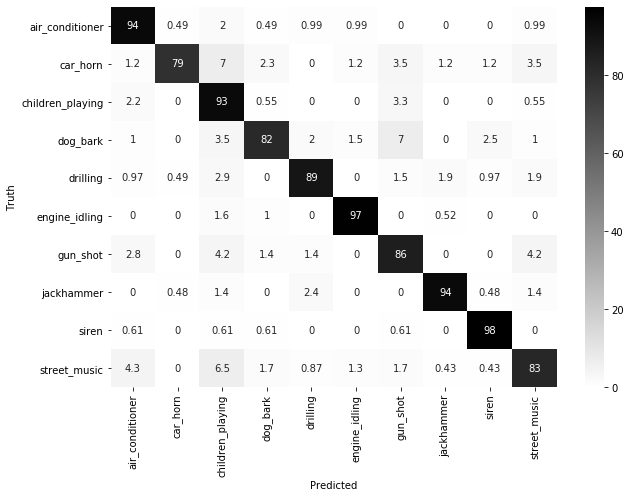

In [49]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Support Vector Machine

In [50]:
# training a linear SVM classifier 
svm_model_linear = SVC(C = 1).fit(x_train, y_train_one_column) 
svm_predictions = svm_model_linear.predict(x_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(x_test, y_test_one_column) 
print (accuracy) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test_one_column, svm_predictions)
print(cm)

0.6153405838580424
[[121   0  18   0  10   5   0  20   0  29]
 [  6  53   5   0   2   7   0   9   1   3]
 [  7   0 113  11  11  10   0   2   8  21]
 [  7   2  19 136   9   5   0   0  10  13]
 [ 10   0  13   6 106   2   0  44   7  18]
 [ 31   0  17   2   0 110   0  22   3   8]
 [  1   0   4  34   6   0  22   1   0   4]
 [ 21   0   1   0  18   1   0 164   0   3]
 [ 11   0   9   8   1   4   0   2 130   0]
 [ 30   0  34   5   5   8   0  23   5 120]]


Text(68.09375, 0.5, 'Truth')

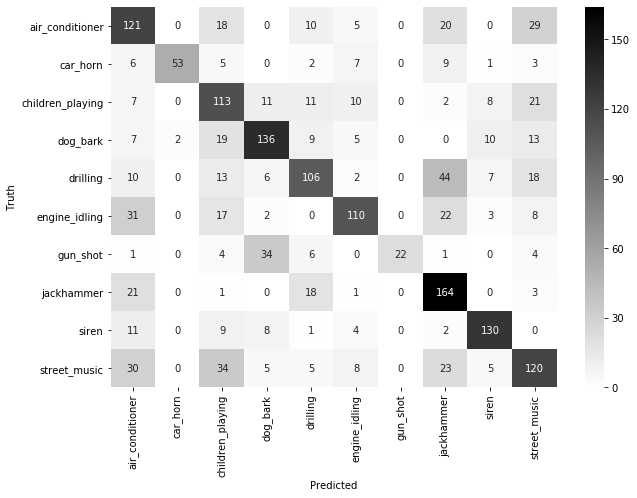

In [51]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d',cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [52]:
cm = confusion_matrix(y_test_one_column, svm_predictions, normalize='true')*100
cm

array([[59.60591133,  0.        ,  8.86699507,  0.        ,  4.92610837,
         2.46305419,  0.        ,  9.85221675,  0.        , 14.28571429],
       [ 6.97674419, 61.62790698,  5.81395349,  0.        ,  2.3255814 ,
         8.13953488,  0.        , 10.46511628,  1.1627907 ,  3.48837209],
       [ 3.82513661,  0.        , 61.74863388,  6.01092896,  6.01092896,
         5.46448087,  0.        ,  1.09289617,  4.3715847 , 11.47540984],
       [ 3.48258706,  0.99502488,  9.45273632, 67.66169154,  4.47761194,
         2.48756219,  0.        ,  0.        ,  4.97512438,  6.46766169],
       [ 4.85436893,  0.        ,  6.31067961,  2.91262136, 51.45631068,
         0.97087379,  0.        , 21.3592233 ,  3.39805825,  8.73786408],
       [16.06217617,  0.        ,  8.80829016,  1.03626943,  0.        ,
        56.99481865,  0.        , 11.39896373,  1.55440415,  4.14507772],
       [ 1.38888889,  0.        ,  5.55555556, 47.22222222,  8.33333333,
         0.        , 30.55555556,  1.38888889

Text(68.09375, 0.5, 'Truth')

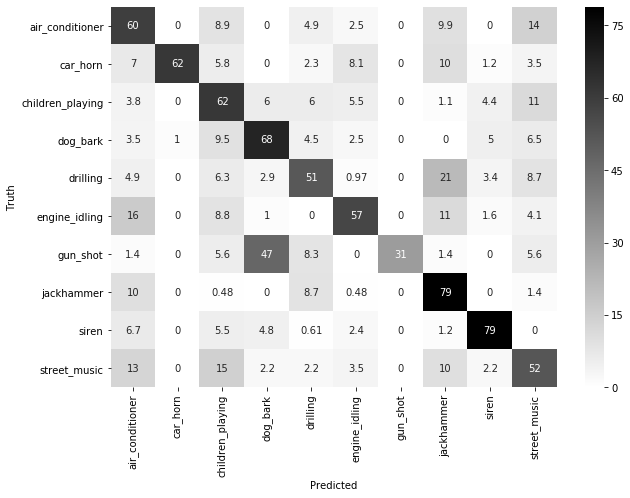

In [53]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="gray_r")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Guardar modelos treinados

In [54]:
import joblib

joblib.dump(knn, 'knnmodel.pkl')

['knnmodel.pkl']

In [55]:
loadedknn=joblib.load('knnmodel.pkl')

In [56]:
loadedknnpredictions=loadedknn.predict(x_test)

In [57]:
knn_predictions

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [58]:
loadedknnpredictions-knn_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
np.max(loadedknnpredictions-knn_predictions)

0.0